This will adapt structure window size

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [4]:
def prepare_structure_data(df):
    """Enhanced feature preparation focusing on important features"""
    features_list = []
    middle_pos = 16  # Center position
    
    # Helper function for normalization
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # 1. Most important features (importance > 0.04) - using ±0 window
    important_features = [
        'bfactor',
        'distance_to_center',
        'sasa',
        'omega',
        'domain_position'
    ]
    
    for feature in important_features:
        feature_arrays = np.array([np.array(eval(x)) for x in df[feature]])
        # Take only the center position
        center_values = feature_arrays[:, middle_pos]
        scaler = RobustScaler()
        scaled_values = scaler.fit_transform(center_values.reshape(-1, 1))
        features_list.append(scaled_values)
    
    # 2. Secondary important features (0.03 < importance < 0.04)
    secondary_features = [
        'chi1', 'chi2', 'chi3', 'chi4',
        'curvature', 'psi', 'phi', 'tau',
        'packing_density', 'local_hydrophobicity'
    ]
    
    for feature in secondary_features:
        feature_arrays = np.array([np.array(eval(x)) for x in df[feature]])
        center_values = feature_arrays[:, middle_pos]
        if feature in ['phi', 'psi', 'omega', 'tau']:
            # Angle features get sin/cos encoding
            angle_features = normalize_angles(center_values)
            features_list.append(angle_features)
        else:
            scaler = RobustScaler()
            scaled_values = scaler.fit_transform(center_values.reshape(-1, 1))
            features_list.append(scaled_values)
    
    # 3. Special case: hydrophobicity with ±1 window
    hydro_arrays = np.array([np.array(eval(x)) for x in df['hydrophobicity']])
    hydro_window = hydro_arrays[:, middle_pos-1:middle_pos+2]  # ±1 window
    scaler = RobustScaler()
    hydro_scaled = scaler.fit_transform(hydro_window.reshape(-1, 1)).reshape(len(hydro_arrays), 3)
    features_list.append(hydro_scaled)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    # Add a dimension for the "sequence" length (1 for center position)
    features = features.reshape(features.shape[0], 1, -1)
    
    return features

In [5]:
def create_combined_model(seq_length=33, struct_features=None, struct_window=0):
    """Create model with both sequence and structure tracks"""
    # Calculate actual window size for structure
    struct_positions = 1 + (2 * struct_window)
    middle_pos = seq_length // 2
    
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', name='seq_features')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)

    # Structure track
    # Structure track with adaptive dense layer size
    struct_input = tf.keras.layers.Input(shape=(1, struct_features), name='structure_input')
    
    # No need for window extraction since we're already providing just the relevant positions
    x_struct = struct_input

    struct_positions = 1 + (2 * struct_window)
    total_struct_features = struct_positions * struct_features
    
    # Make dense layer size proportional to input features
    struct_dense_size = min(total_struct_features * 2, 128)  # or another scaling rule
        
    x_struct = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    x_struct = tf.keras.layers.Flatten()(x_struct)
    x_struct = tf.keras.layers.Dense(struct_dense_size, activation='relu')(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    
    # Create learnable weights layer
    weight_layer = tf.keras.layers.Dense(2, activation='softmax', name='track_weights')
    track_weights = weight_layer(tf.keras.layers.Concatenate()([x_seq, x_struct]))
    
    # Apply weights using layers
    weighted_seq = tf.keras.layers.Multiply(name='weighted_seq')([
        x_seq,
        tf.keras.layers.Lambda(lambda x: x[:, 0:1])(track_weights)
    ])
    
    weighted_struct = tf.keras.layers.Multiply(name='weighted_struct')([
        x_struct,
        tf.keras.layers.Lambda(lambda x: x[:, 1:2])(track_weights)
    ])
    
    # Combine weighted features
    combined = tf.keras.layers.Concatenate()([weighted_seq, weighted_struct])
    
    # Final layers
    x = tf.keras.layers.Dense(32, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[seq_input, struct_input], outputs=outputs)
    
    def get_track_weights():
        # Get the weights and bias from the weight layer
        w = model.get_layer('track_weights').get_weights()
        if len(w) > 0:
            weights = w[0]
            bias = w[1] if len(w) > 1 else 0
            # Calculate softmax
            exp_weights = np.exp(np.mean(weights, axis=0) + bias)
            normalized = exp_weights / np.sum(exp_weights)
            return {
                'sequence': float(normalized[0]),
                'structure': float(normalized[1])
            }
        return {'sequence': 0.5, 'structure': 0.5}
    
    model.get_track_weights = get_track_weights
    
    return model

In [8]:
def train_and_evaluate(struct_window=0):
    """Training function with track weights"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_features_train_latest.csv")
    test_df = pd.read_csv("../data/processed_features_test_latest.csv")
    
    # Prepare data
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    X_train_struct = prepare_structure_data(train_df)
    X_test_struct = prepare_structure_data(test_df)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    # Shuffle data
    train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    # Print class distribution
    print("\nTraining set distribution:")
    print(train_df['label'].value_counts())
    print("\nTest set distribution:")
    print(test_df['label'].value_counts())
    
    # Print data shapes
    print("\nData shapes:")
    print(f"X_train_seq: {X_train_seq.shape}")
    print(f"X_train_struct: {X_train_struct.shape}")
    print(f"X_test_seq: {X_test_seq.shape}")
    print(f"X_test_struct: {X_test_struct.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    track_weights_history = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_combined_model(
            seq_length=33,
            struct_features=X_train_struct.shape[2],
            struct_window=struct_window
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [X_train_seq[train_idx], X_train_struct[train_idx]], 
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_struct[val_idx]], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict([X_train_seq[val_idx], X_train_struct[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))  # Sensitivity
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))  # Specificity
        
        # Predict on test set
        test_pred = model.predict([X_test_seq, X_test_struct])
        test_predictions.append(test_pred)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
        
        # After training, get and store the learned weights
        final_weights = model.get_track_weights()
        track_weights_history.append(final_weights)
        print(f"\nLearned track weights for fold {fold}:")
        print(f"Sequence weight: {final_weights['sequence']:.4f}")
        print(f"Structure weight: {final_weights['structure']:.4f}")
    
    # Calculate average weights
    avg_seq_weight = np.mean([w['sequence'] for w in track_weights_history])
    avg_struct_weight = np.mean([w['structure'] for w in track_weights_history])
    std_seq_weight = np.std([w['sequence'] for w in track_weights_history])
    std_struct_weight = np.std([w['structure'] for w in track_weights_history])
    
    print("\nAverage track weights across folds:")
    print(f"Sequence weight: {avg_seq_weight:.4f} ± {std_seq_weight:.4f}")
    print(f"Structure weight: {avg_struct_weight:.4f} ± {std_struct_weight:.4f}")
        
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
        
    return model

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 1, 21)
X_test_seq: (2737, 33)
X_test_struct: (2737, 1, 21)
y_train: (8850,)
y_test: (2737,)

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-11 13:17:06.943228: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-11 13:17:06.943259: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-11 13:17:06.943268: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-11 13:17:06.943483: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-11 13:17:06.943500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-12-11 13:17:07.827717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.5613 - loss: 0.6863 - val_accuracy: 0.6085 - val_loss: 0.6576 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6247 - loss: 0.6497 - val_accuracy: 0.6921 - val_loss: 0.6012 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7005 - loss: 0.5753 - val_accuracy: 0.7463 - val_loss: 0.5332 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7353 - loss: 0.5284 - val_accuracy: 0.7582 - val_loss: 0.5080 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7606 - loss: 0.5016 - val_accuracy: 0.7565 - val_loss: 0.5111 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7825 - loss: 0.4821 - val_accuracy: 0.7599 - val_loss: 0.5076 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7819 - loss: 0.4628 - val

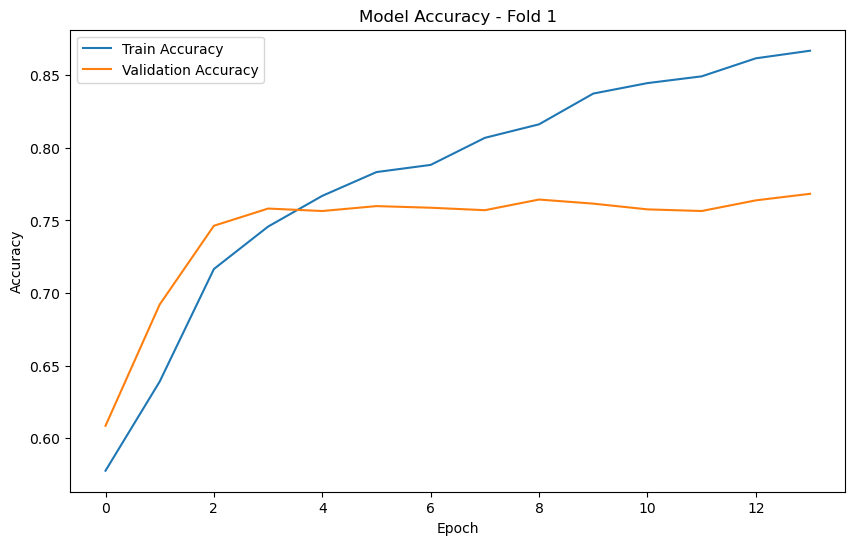

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7644
Balanced Accuracy: 0.7629
MCC: 0.5289
Sensitivity: 0.8105
Specificity: 0.7153

Learned track weights for fold 1:
Sequence weight: 0.5588
Structure weight: 0.4412

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5410 - loss: 0.6883 - val_accuracy: 0.6463 - val_loss: 0.6660 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6064 - loss: 0.6589 - val_accuracy: 0.6825 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7210 - loss: 0.5716 - val_accuracy: 0.7441 - val_loss: 0.5156 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7418 - loss: 0.5320 - val_accuracy: 0.7599 - val_loss: 0.4986 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7530 - loss: 0.5129 - val_accuracy: 0.7621 - val_loss: 0.4902 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7695 - loss: 0.4949 - val_accuracy: 0.7565 - val_loss: 0.4891 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7820 - loss: 0.4722 - val_

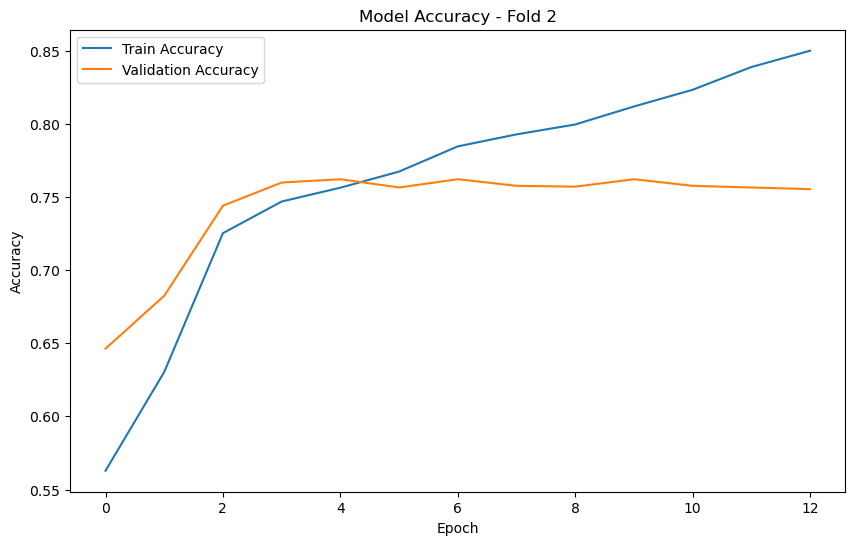

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7576
Balanced Accuracy: 0.7565
MCC: 0.5133
Sensitivity: 0.7767
Specificity: 0.7362

Learned track weights for fold 2:
Sequence weight: 0.5338
Structure weight: 0.4662

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5564 - loss: 0.6852 - val_accuracy: 0.6141 - val_loss: 0.6672 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6098 - loss: 0.6593 - val_accuracy: 0.6395 - val_loss: 0.6468 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6377 - loss: 0.6407 - val_accuracy: 0.6684 - val_loss: 0.6107 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6664 - loss: 0.6105 - val_accuracy: 0.6876 - val_loss: 0.5912 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7024 - loss: 0.5850 - val_accuracy: 0.6966 - val_loss: 0.5773 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7274 - loss: 0.5535 - val_accuracy: 0.7006 - val_loss: 0.5622 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7360 - loss: 0.5362 - val

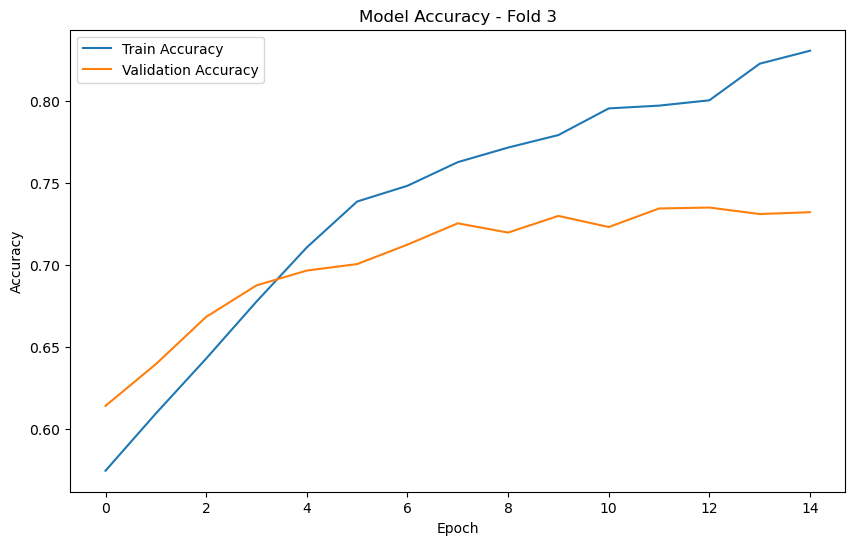

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7299
Balanced Accuracy: 0.7307
MCC: 0.4616
Sensitivity: 0.7054
Specificity: 0.7561

Learned track weights for fold 3:
Sequence weight: 0.5336
Structure weight: 0.4664

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.5376 - loss: 0.6929 - val_accuracy: 0.5723 - val_loss: 0.6647 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6464 - loss: 0.6366 - val_accuracy: 0.6797 - val_loss: 0.5997 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7190 - loss: 0.5639 - val_accuracy: 0.7266 - val_loss: 0.5473 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7533 - loss: 0.5246 - val_accuracy: 0.7452 - val_loss: 0.5258 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7662 - loss: 0.5005 - val_accuracy: 0.7588 - val_loss: 0.5078 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7703 - loss: 0.4858 - val_accuracy: 0.7599 - val_loss: 0.5040 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7749 - loss: 0.4702 - val

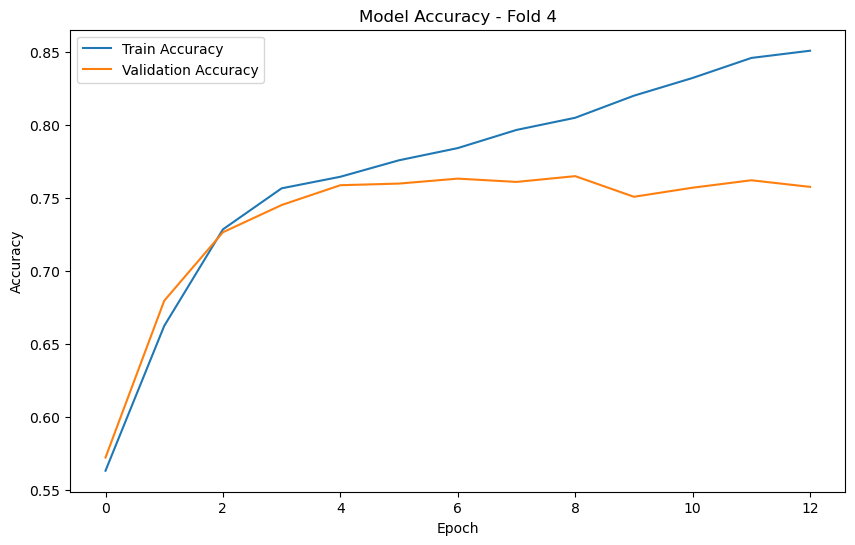

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4 Results:
Accuracy: 0.7610
Balanced Accuracy: 0.7602
MCC: 0.5213
Sensitivity: 0.7853
Specificity: 0.7351

Learned track weights for fold 4:
Sequence weight: 0.5422
Structure weight: 0.4578

Fold 5/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5513 - loss: 0.6836 - val_accuracy: 0.5904 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6146 - loss: 0.6523 - val_accuracy: 0.6633 - val_loss: 0.6309 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6752 - loss: 0.6138 - val_accuracy: 0.6898 - val_loss: 0.5926 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7151 - loss: 0.5663 - val_accuracy: 0.7316 - val_loss: 0.5418 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7454 - loss: 0.5255 - val_accuracy: 0.7469 - val_loss: 0.5258 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7642 - loss: 0.5013 - val_accuracy: 0.7525 - val_loss: 0.5139 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.7774 - loss: 0

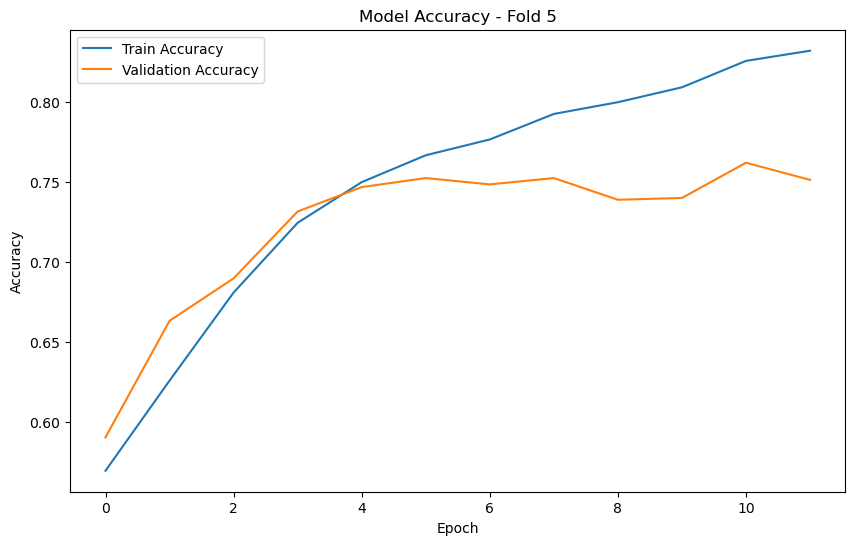

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7486
Balanced Accuracy: 0.7491
MCC: 0.4979
Sensitivity: 0.7350
Specificity: 0.7632

Learned track weights for fold 5:
Sequence weight: 0.5532
Structure weight: 0.4468

Average track weights across folds:
Sequence weight: 0.5443 ± 0.0102
Structure weight: 0.4557 ± 0.0102

Average Cross-validation Results:
ACC: 0.7523 ± 0.0124
BALANCED_ACC: 0.7519 ± 0.0115
MCC: 0.5046 ± 0.0238
SN: 0.7626 ± 0.0375
SP: 0.7412 ± 0.0170

Final Test Set Results:
Accuracy: 0.7322
Balanced Accuracy: 0.7610
MCC: 0.3165
Sensitivity: 0.7958
Specificity: 0.7261
Confusion Matrix:
[[1813  684]
 [  49  191]]


In [9]:
if __name__ == "__main__":
    model = train_and_evaluate()